# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

This project intends to predict salaries for given job descriptions.

Job descriptions have eight __features__:
* __jobId__ = a unique index for each job
* __companyId__ = a categorical ID for the company the job is for
* __jobType__ = a categorical feature describing the role
* __degree__ = a categorical feature describing the required education level
* __major__ = a categorical feature conveying the field in which a degree is required, if any
* __industry__ = a categorical feature describing the industry to which the job belongs
* __yearsExperience__ = a numerical feature measuring how many years of work experience are required for the role
* __milesFromMetropolis__ = a numerical feature measuring how far the workplace is located from a metropolis

The __target__ is __salary__ (in 1000 USD). Salaries are given in the training set and need to be predicted for the test set.

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from eda.stats import interquartile_rule
from eda import plot

# Author information
__author__ = "Paawan Sharma"
__email__ = "paawansharma@protonmail.com"

The following cell prevents jupyter from creating scrollable subframes for plots, instead showing the entire set of generated plots without the need for scrolling.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
# Load the training and test data in pandas DataFrames

train_data = pd.read_csv('../data/train_features.csv', header=0)
train_data['salary'] = pd.read_csv('../data/train_salaries.csv', header=0)['salary']

test_data = pd.read_csv('../data/test_features.csv', header=0)

#### Take an initial look at the data.

In [4]:
display(train_data)
display(train_data.info())

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


None

In [5]:
display(test_data)
display(test_data.info())

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
...,...,...,...,...,...,...,...,...
999995,JOB1362686407682,COMP54,VICE_PRESIDENT,BACHELORS,MATH,OIL,14,3
999996,JOB1362686407683,COMP5,MANAGER,NONE,NONE,HEALTH,20,67
999997,JOB1362686407684,COMP61,JANITOR,NONE,NONE,OIL,1,91
999998,JOB1362686407685,COMP19,CTO,DOCTORAL,MATH,OIL,14,63


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


None

### ---- 3 Clean the data ----

#### Look for duplicate data in the training set. Duplicate job IDs may indicate corrupt data.

In [6]:
print("There are {} duplicate rows in the training set.".format(train_data.duplicated().sum()))
print("There are {} duplicate jobIDs in the training set.".format(train_data['jobId'].duplicated().sum()))

There are 0 duplicate rows in the training set.
There are 0 duplicate jobIDs in the training set.


#### Look for invalid data.

We know from earlier that there are no null values. We can check that all values are appropriate for each variable.

In [7]:
# Numerical features in both dataframes

for df_name, df in {"test set": test_data, "training set": train_data}.items():
    print("Checking {}".format(df_name))
    print("Are all years of experience non-negative?")
    print(df[df['yearsExperience'] < 0].empty)
    print("Are all miles from metropolis non-negative?")
    print(df[df['milesFromMetropolis'] < 0].empty)
    print("\n")
    
print("Are all salary values in training set positive?")
print(train_data[train_data['salary'] <= 0].empty)

Checking test set
Are all years of experience non-negative?
True
Are all miles from metropolis non-negative?
True


Checking training set
Are all years of experience non-negative?
True
Are all miles from metropolis non-negative?
True


Are all salary values in training set positive?
False


#### Observe jobs whose salaries are not positive

In [8]:
train_data[train_data['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


None of these salaries is negative. A salary can be zero (or rounded down to zero) if the employee opts to receive alternative compensation so these data may be valid. However, it is also possible these are missing values. Since the training dataset is large (1,000,000 samples), it is safe to drop these samples.

In [9]:
train_data.drop(train_data[train_data['salary'] == 0].index, inplace=True)
print("The number of samples is now {:,}.".format(train_data.shape[0]))

The number of samples is now 999,995.


In [10]:
# Categorical features in both dataframes

for df_name, df in {"training set": train_data, "test set": test_data}.items():
    print("Checking {}\n".format(df_name))
    for feature in ['jobType', 'degree', 'major', 'industry']:
        print("Values for {} are: {}\n".format(feature, list(df[feature].unique())))
    print("\n")

Checking training set

Values for jobType are: ['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']

Values for degree are: ['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']

Values for major are: ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']

Values for industry are: ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']



Checking test set

Values for jobType are: ['MANAGER', 'JUNIOR', 'CTO', 'SENIOR', 'CEO', 'VICE_PRESIDENT', 'JANITOR', 'CFO']

Values for degree are: ['HIGH_SCHOOL', 'NONE', 'MASTERS', 'DOCTORAL', 'BACHELORS']

Values for major are: ['NONE', 'BIOLOGY', 'COMPSCI', 'PHYSICS', 'LITERATURE', 'MATH', 'CHEMISTRY', 'ENGINEERING', 'BUSINESS']

Values for industry are: ['HEALTH', 'AUTO', 'OIL', 'FINANCE', 'SERVICE', 'EDUCATION', 'WEB']





All values appear to be valid.

#### Check that majors are only given for jobs that require degrees

In [11]:
list(train_data[train_data['major'] != "NONE"].degree.unique())

['MASTERS', 'DOCTORAL', 'BACHELORS']

#### As jobIDs are unique, we can set them as the indices for the dataframes.

In [12]:
for df in [train_data, test_data]:
    df.set_index('jobId', inplace=True)

#### Finally, check that none of the training jobIds are repeated in the test set.

In [13]:
print("The intersection contains {} samples.".format(train_data.index.intersection(test_data.index).size))

The intersection contains 0 samples.


### ---- 4 Explore the data (EDA) ----

#### Start by getting a description of all categorical and numerical variables.

In [14]:
train_data.describe(include=['O'])

,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,16193,125886,236975,532353,143205


It is noteworthy that there are 63 different companies in the dataset. The other categorical features have few unique values and therefore will probably be more useful to models.

In [15]:
train_data.describe(include=np.number)

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


All numerical ranges seem reasonable.

#### Explore the distribution of the target (salary).

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


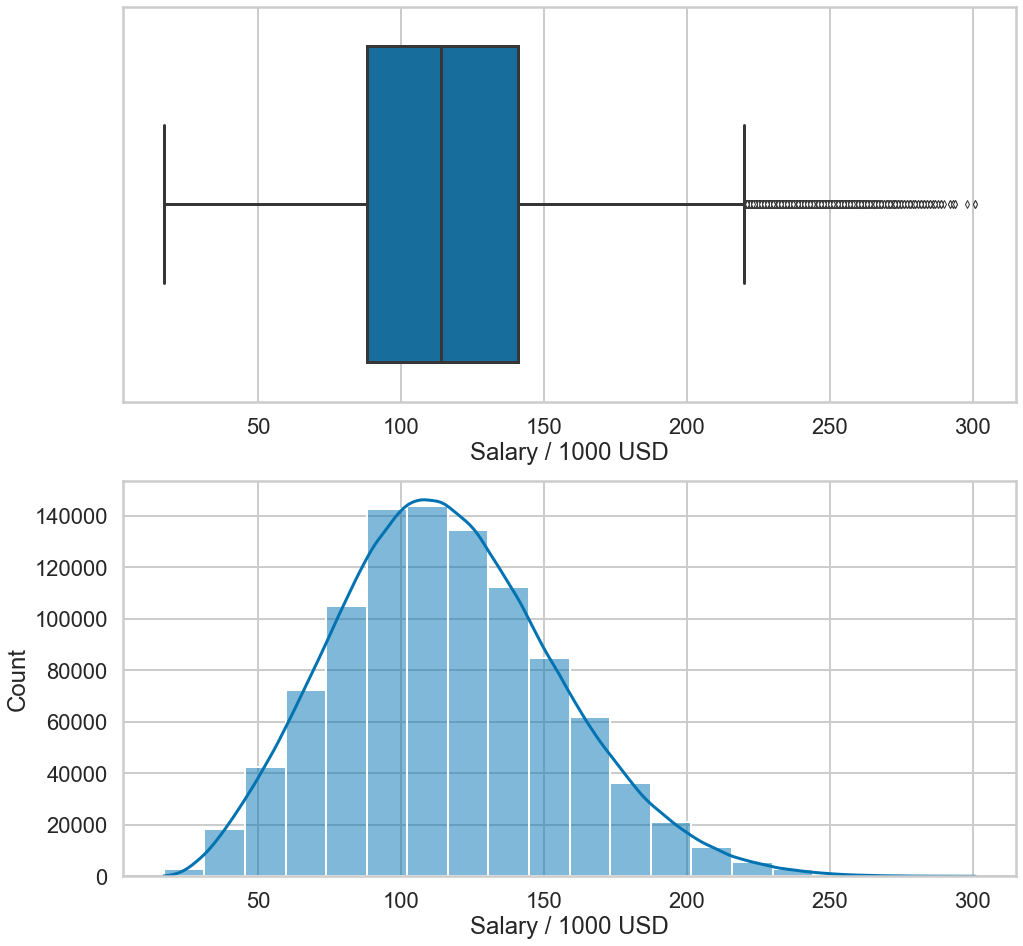

In [16]:
sns.set_theme(style='whitegrid', palette='colorblind')
sns.set_context('poster')

plot.plot_target('salary', train_data, target_label="Salary / 1000 USD")

The salary is approximately normally distributed. There are some outliers on the upper end of the distribution. These can be explored using the interquartile rule for outliers.

In [17]:
salary_outliers, salary_uppers, salary_lowers = interquartile_rule('salary', train_data)

print("There are {} lower outliers.".format(salary_lowers))

for feature in ['jobType', 'degree', 'industry']:
    display(salary_outliers[feature].value_counts())

There are 0 lower outliers.


CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

DOCTORAL       2981
MASTERS        2134
BACHELORS      1440
HIGH_SCHOOL     354
NONE            208
Name: degree, dtype: int64

OIL          2368
FINANCE      2200
WEB          1280
HEALTH        631
AUTO          325
SERVICE       200
EDUCATION     113
Name: industry, dtype: int64

The bulk of the outliers, which are all upper outliers, correspond to typically high-paying roles, high educational qualifications and profitable industries (such as oil and finance). This is to be expected and provides confidence in the validity of the data.

It is worthwhile to explore those outliers which require no educational qualification. There are 208 such outliers.

In [18]:
salary_outliers[salary_outliers.degree == "NONE"].jobType.value_counts()

CEO               124
CFO                41
CTO                35
VICE_PRESIDENT      8
Name: jobType, dtype: int64

These are all typically high-paying roles, which is a good indication.

#### Investigate counts and correlations with salary for each categorical feature

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/si

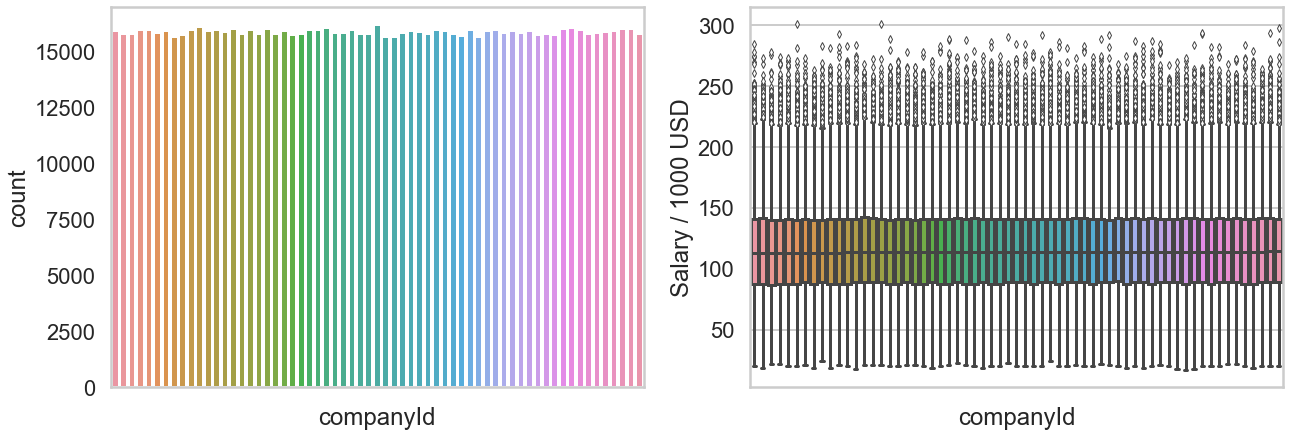

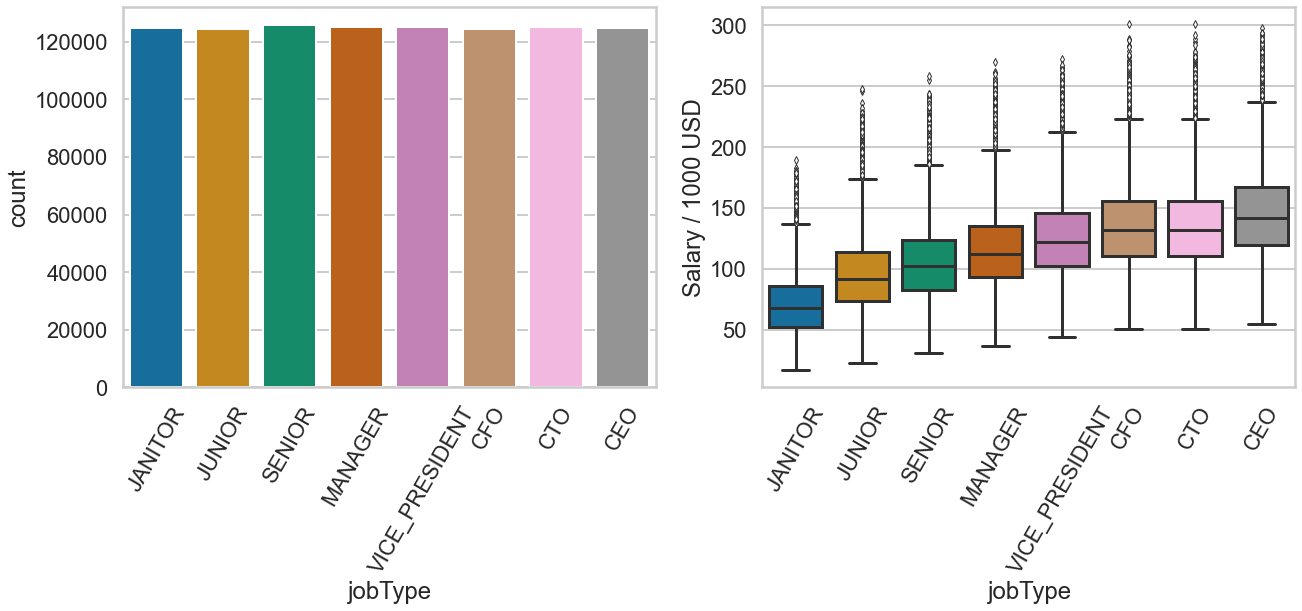

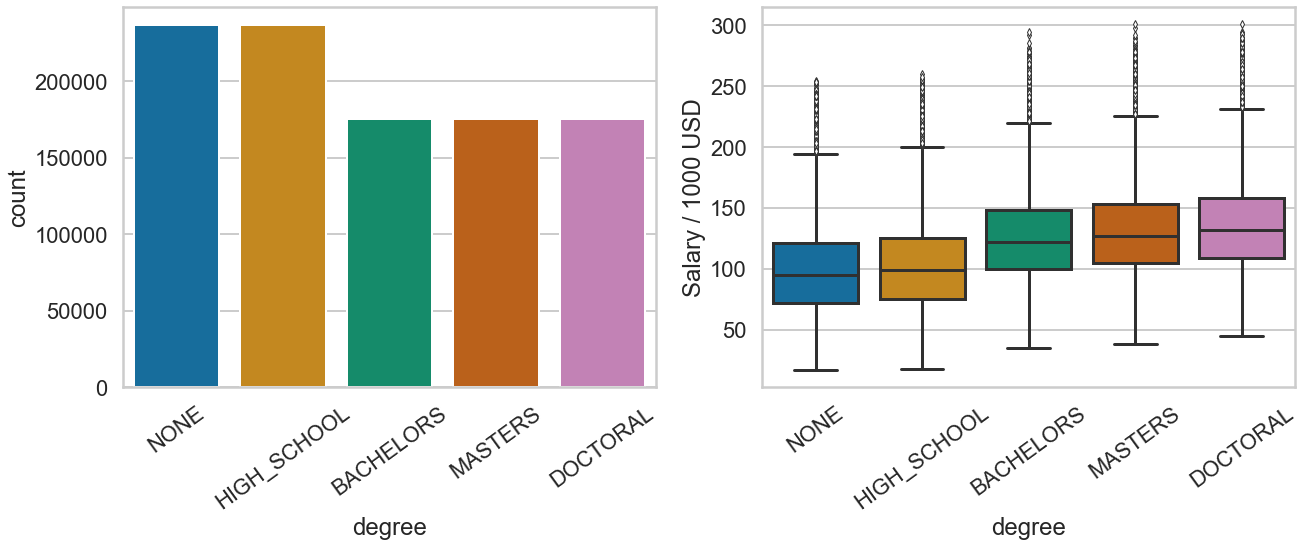

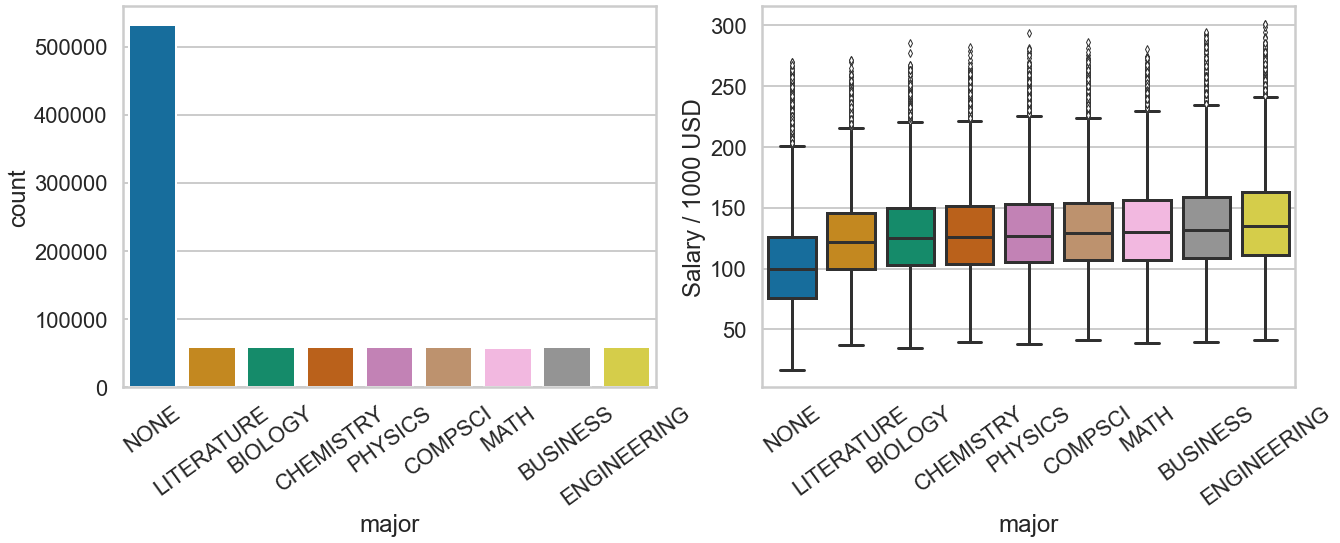

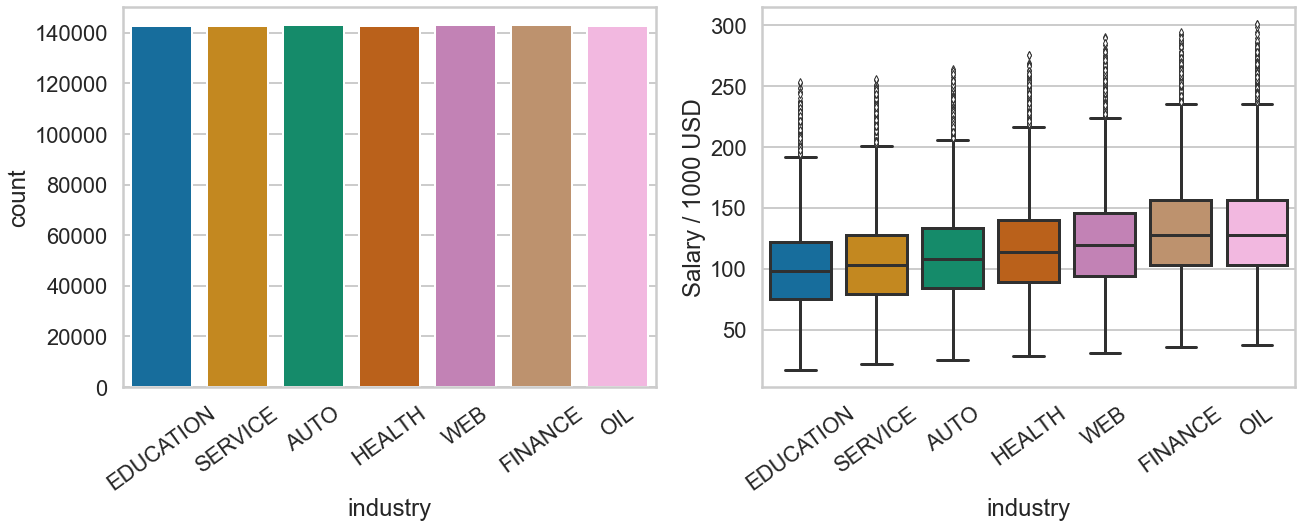

In [19]:
categoricals = list(train_data.columns[train_data.dtypes == 'object'])
numericals = list(train_data.columns[train_data.dtypes == 'int64'])[:-1]


for feature in categoricals:
    plot.plot_categorical(feature, 'salary', train_data)

__companyId__ has no correlation, or a very weak correlation, with salary. It is worth investigating whether the number of dataset samples belonging to a given company has any relationship with salary.

__jobType__ shows a clear correlation with salary.

__degree__ shows a clear difference in salaries between those without a degree and those with one. Beyond this, the correlation is slight.

__major__ shows a very slight correlation, with engineering being the major corresponding to the highest median salary.

__industry__ shows a clear correlation, with oil and finance having the highest median salaries.

/Users/paawansharma/Desktop/Salaries-Project/code/eda/plot.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  plotted.set_xticklabels(plotted.get_xticklabels(), rotation=rot_angle)


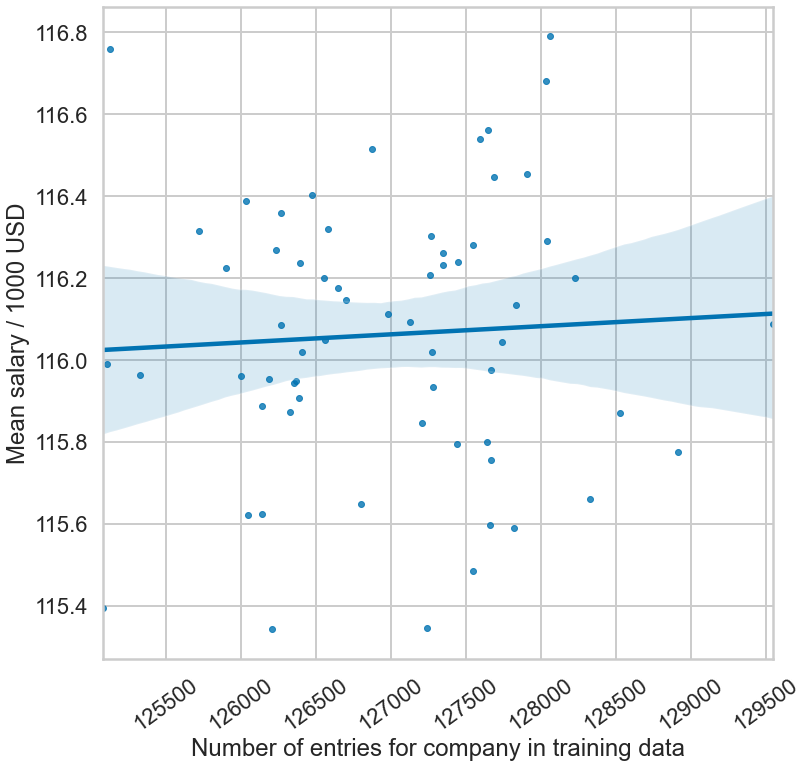

In [20]:
plot.categorical_correlation(feature='companyId',
                             target='salary',
                             dataframe=train_data,
                             groupfunc=np.size,
                            x_label='Number of entries for company in training data',
                            y_label='Mean salary / 1000 USD')

There is a very slight positive correlation between the number of jobs the company has in the training data and the mean salary for jobs in that company.

#### Investigate associations of numerical features with salary

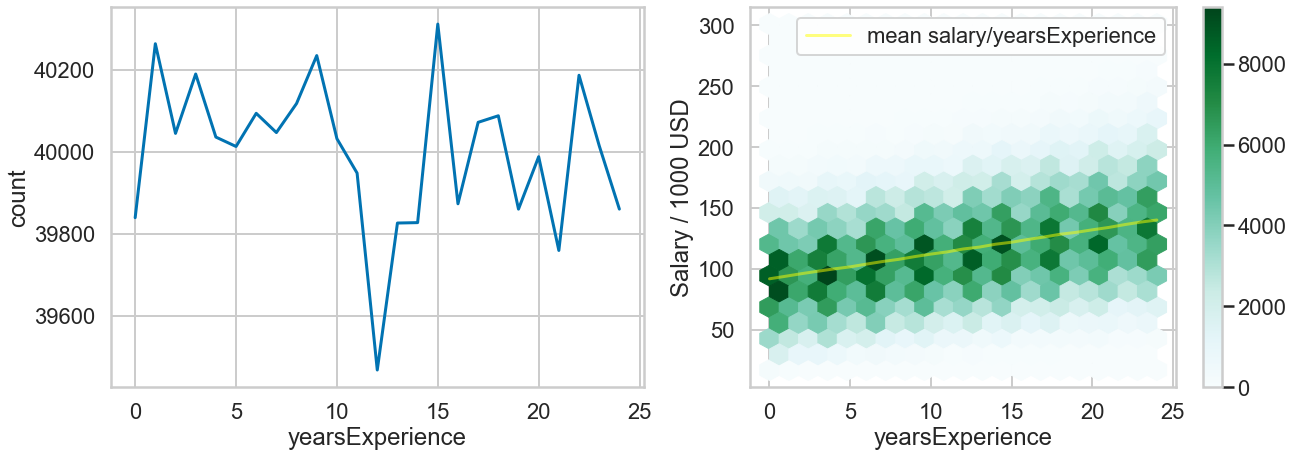

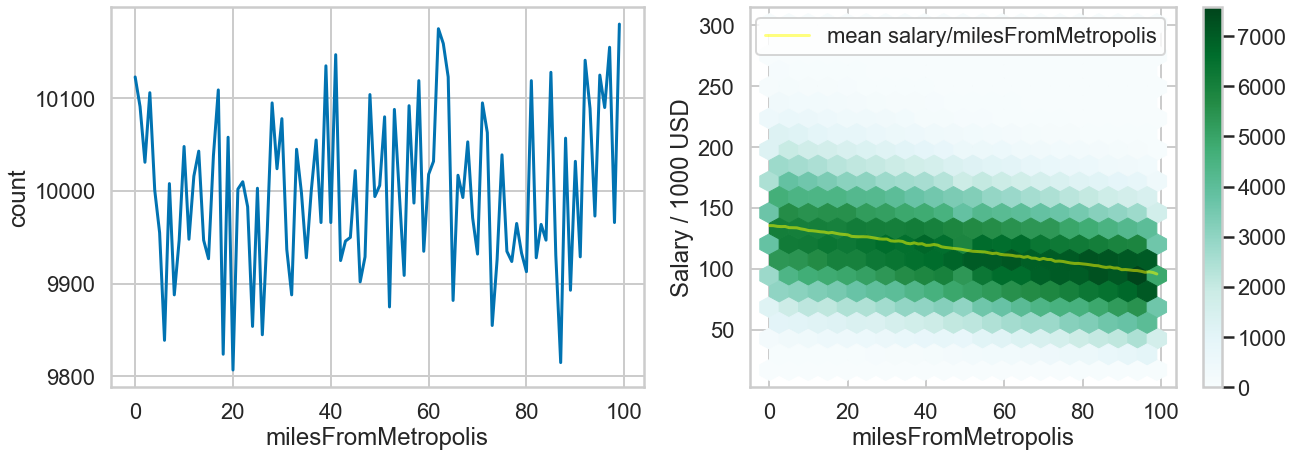

In [21]:
for feature in numericals:
    plot.plot_numerical(feature, 'salary', train_data, target_unit='1000 USD')